# Uncertainty of efficiency  from fitted decay yields

We derive an approximate formula to compute the uncertainty of the efficiency computed from fitted yields of some decays. The formula is suitable to draw error bars in plots.

In [1]:
import numpy as np
from iminuit import Minuit
from iminuit.cost import ExtendedBinnedNLL, NormalConstraint
from numba_stats import bernstein, norm
from matplotlib import pyplot as plt
from scipy.stats import median_abs_deviation
from sympy import *

## Without background

I will re-derive the common normal approximation for the uncertainty of an efficiency, see [Wikipedia](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) for details, in a particular way that will make the generalization to the case with background clear.

The first insight is that the efficiency can be written in terms of two independently Poisson-distributed numbers $n_\text{pass}$ and $n_\text{fail}$,

$$
\epsilon = \frac{n_\text{pass}}{n_\text{pass} + n_\text{fail}}.
$$

In the typical particle physics experiment, die total number of events is not fixed, since the measurement is fundamentally a rate measurement (one waits a fixed time and measures how often something happens). In that case, the two numbers are indeed independently Poisson distributed and not binomially distributed.

In a particular sample, the sample value $\hat n$ will deviate from the expectation value $n$ by a random offset,

$$
\hat n = n + z \sigma_\text{poisson} = n + z \sqrt{n},
$$

where $z$ is approximately standard-normal distributed for sufficiently large $n$. The sample value of the efficiency then is

$$
\hat \epsilon = \frac{\hat n_\text{pass}}{\hat n_\text{pass} + \hat n_\text{fail}} = \frac{n_\text{pass} + z_1 \sqrt{n_\text{pass}}}{n_\text{pass} + n_\text{fail} + z_1 \sqrt{n_\text{pass}} + z_2 \sqrt{n_\text{fail}}}.
$$

The variance of $\hat \epsilon$ can be computed via standard error propagation, using that the $z_i$ are independent and standard normal,

$$
\sigma^2(\hat \epsilon) = \left[\left(\frac{\text{d}\hat \epsilon}{\text{d}z_1}\right)^2 + \left(\frac{\text{d}\hat \epsilon}{\text{d}z_2}\right)^2\right]_{z_1 = 0,\, z_2=0}.
$$

Let's compute this with SymPy.

In [2]:
n_pass, n_fail, n, z1, z2 = symbols("n_pass n_fail n z_1 z_2", real=True)

f = (n_pass + z1 * sqrt(n_pass)) / \
    (n_pass + z1 * sqrt(n_pass) + n_fail + z2 * sqrt(n_fail)); f

(sqrt(n_pass)*z_1 + n_pass)/(sqrt(n_fail)*z_2 + n_fail + sqrt(n_pass)*z_1 + n_pass)

In [3]:
f_var = sum(diff(f, z) ** 2 for z in (z1, z2))
f_var = f_var.subs([(z1, 0), (z2, 0)])
f_var = f_var.simplify(); f_var

n_fail*n_pass/(n_fail + n_pass)**3

This is the square of the formula in the [Wikipedia](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval),

$$
\sigma(\hat \epsilon) = \frac{1}{\sqrt{n}n} \sqrt{n_\text{pass} n_\text{fail}},
$$

with $n = n_\text{pass} + n_\text{fail}$, as expected. The values that appear in the formula are the unknown expectation values $n_\text{pass}$, $n_\text{fail}$, and $n$; which are replaced by their sample estimates $\hat n_\text{pass}$ etc. in practice (this is an application of the plug-in principle on which also bootstrap theory is based).

Let's check this formula against the true standard deviation of $\hat \epsilon$ in toy simulations.

In [4]:
f_var = lambdify([n_pass, n_fail], f_var)

In [5]:
rng = np.random.default_rng(1)
eps = np.linspace(0, 1, 100)
data = {}
for n in (10, 20, 50, 100, 1000):
    s1 = []
    s2 = []
    for epsi in eps:
        n_pass = rng.poisson(n * epsi, size=10000)
        n_fail = rng.poisson(n * (1 - epsi), size=10000)
        ma = n_pass + n_fail > 0
        n_pass = n_pass[ma]
        n_fail = n_fail[ma]
        s1.append(np.std(n_pass / (n_pass + n_fail)))
        # it is important to average the variance instead of the standard deviation
        s2.append(np.mean(f_var(n_pass, n_fail)) ** 0.5)
    data[n] = np.array((eps, s1, s2))

n=10 median deviation 0.08
n=20 median deviation 0.03
n=50 median deviation 0.01
n=100 median deviation 0.00
n=1000 median deviation 0.00


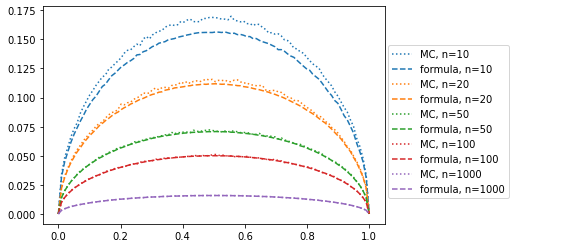

In [6]:
plt.figure(figsize=(10, 4))
for n, (eps, s1, s2) in data.items():
    l, = plt.plot(eps, s1, ":", label=f"MC, {n=}")
    plt.plot(eps, s2, "--", color=l.get_color(), label=f"formula, {n=}")
    print(f"{n=} median deviation {np.median(s1[s2 > 0] / s2[s2 > 0]) - 1:.2f}")
plt.subplots_adjust(right=0.6)
plt.figlegend(loc=(0.68, 0.2));

There is some bias for small $n$, which originates from the fact that the Poisson fluctuations are not normally distributed for small $n$. Nevertheless, the derived formula does reasonably well with deviations less than 10 % even for $n > 10$. This is usually sufficient to calculate error bars for efficiency plots.

## With background

We now assume that the estimates $\hat n_\text{pass}$ and $\hat n_\text{fail}$ cannot obtained by direct counting, but need to be estimated from a fit that inclues a signal and background component. If the fit is unbiased, the average contribution from the background is zero, which we will assume, but it enlargens the uncertainty of the estimate.

We can model this by adding a random contribution from the background to our estimate,

$$
\hat n = n + z_1 \sigma_\text{poisson} + z_2 \sigma_\text{bkg} = n + z_1 \sqrt{n} + z_2 \sigma_\text{bkg}.
$$

The expected variance of $\hat n$ then is

$$
\sigma^2(\hat n) = n + \sigma^2_\text{bkg}.
$$

There is a contribution from the Poisson fluctuations as before and an additional one from the background. In practice, estimating $\sigma^2_\text{bkg}$ directly is very difficult, but fortunately, the left-hand side $\sigma^2(\hat n)$ can be estimated from the fit (MINUITs Hesse error). Thus we can compute an estimate for the unknown $\sigma^2_\text{bkg}$ with the formula,

$$
\sigma^2_\text{bkg} = \sigma^2(\hat n) -  n.
$$

In practice, we have to replace the expectation values $\sigma^2(\hat n)$ and $n$ with the corresponding estimates from the fit.

We insert this into the formula for $\hat \epsilon$ and get:

$$
\hat \epsilon = \frac{\hat n_\text{pass}}{\hat n_\text{pass} + \hat n_\text{fail}} = \frac{n_\text{pass} + z_1 \sqrt{n_\text{pass}} + z_2 \sigma_\text{bkg,pass}}{n_\text{pass} + n_\text{fail} + z_1 \sqrt{n_\text{pass}} + z_2 \sigma_\text{bkg,pass} + z_3 \sqrt{n_\text{fail}} + z_4 \sigma_\text{bkg,fail}}
$$

As before, the variance of $\hat \epsilon$ is computed via standard error propagation, using that the $z_i$ are independent and standard normal. This reflects the assumption that the background in both fits is independently sampled, which in practice is usually not exactly true. If the correlation can be estimated, it can be trivially included in the calculation, but I will not do this here.

$$
\sigma^2(\hat \epsilon) = \left[\left(\frac{\text{d}\hat \epsilon}{\text{d}z_1}\right)^2 + \left(\frac{\text{d}\hat \epsilon}{\text{d}z_2}\right)^2 + 
\left(\frac{\text{d}\hat \epsilon}{\text{d}z_3}\right)^2 +
\left(\frac{\text{d}\hat \epsilon}{\text{d}z_4}\right)^2
\right]_{z_1 = 0,\, z_2=0,\,z_3=0,\,z_4=0}.
$$

The calculation is even more tedious then before, so let's do it again with SymPy.

In [7]:
(n_pass, n_fail, sigma_pass, sigma_fail,
 sigma_bkg_pass, sigma_bkg_fail,
 z1, z2, z3, z4) = symbols(
    "n_pass n_fail sigma_pass sigma_fail "
    "sigma_bkg_pass sigma_bkg_fail "
    "z_1 z_2 z_3 z_4", real=True)

g = (n_pass + z1 * sqrt(n_pass) + z2 * sigma_bkg_pass) / \
    (n_pass + n_fail
     + z1 * sqrt(n_pass) + z2 * sigma_bkg_pass 
     + z3 * sqrt(n_fail) + z4 * sigma_bkg_fail); g

(sqrt(n_pass)*z_1 + n_pass + sigma_bkg_pass*z_2)/(sqrt(n_fail)*z_3 + n_fail + sqrt(n_pass)*z_1 + n_pass + sigma_bkg_fail*z_4 + sigma_bkg_pass*z_2)

In [8]:
g = g.subs([(sigma_bkg_pass, sqrt(sigma_pass ** 2  - n_pass)), 
            (sigma_bkg_fail, sqrt(sigma_fail ** 2 - n_fail))]); g

(sqrt(n_pass)*z_1 + n_pass + z_2*sqrt(-n_pass + sigma_pass**2))/(sqrt(n_fail)*z_3 + n_fail + sqrt(n_pass)*z_1 + n_pass + z_2*sqrt(-n_pass + sigma_pass**2) + z_4*sqrt(-n_fail + sigma_fail**2))

In [9]:
g_var = sum(diff(g, z) ** 2 for z in (z1, z2, z3, z4))
g_var = g_var.subs([(z1, 0), (z2, 0), (z3, 0), (z4, 0)])
g_var = g_var.simplify(); g_var

(n_fail**2*sigma_pass**2 + n_pass**2*sigma_fail**2)/(n_fail + n_pass)**4

We thus obtain

$$
\sigma^2(\hat \epsilon) = \frac{
n_\text{pass}^2 \, \sigma^2(n_\text{fail}) +
n_\text{fail}^2 \, \sigma^2(n_\text{pass})
}{n^4},
$$

with $n = n_\text{pass} + n_\text{fail}$. In practice, $n_\text{pass}$, $\sigma^2(n_\text{pass})$, etc. are replaced with their fit estimates.

We can recover the previous formula, which is a special case, by setting $\sigma^2(n) = n$ (no background contribution),

$$
\frac{
n_\text{pass}^2 \, \sigma^2(n_\text{fail}) +
n_\text{fail}^2 \, \sigma^2(n_\text{pass})
}{n^4} = 
\frac{
n_\text{pass}^2 \, n_\text{fail} +
n_\text{fail}^2 \, n_\text{pass}
}{n^4} =
\frac{
n_\text{pass} \, n_\text{fail} \, (n_\text{pass} + n_\text{fail})
}{n^4} =
\frac{
n_\text{pass} \, n_\text{fail}
}{n^3}.
$$

In [10]:
g_var = lambdify([n_pass, sigma_pass, n_fail, sigma_fail], g_var)

In [11]:
rng = np.random.default_rng(1)
eps = np.linspace(0, 1, 10)

def model(x, b0, b1, b2, s, mu, sigma):
    nb = bernstein.scaled_cdf(x, (b0, b1, b2), -1, 1)
    ns = s * norm.cdf(x, mu, sigma)
    return ns + nb

def reject_extreme_outliers(t):
    t = np.array(t)
    t = t[~np.isnan(t)]
    s = median_abs_deviation(t, scale="normal")
    ma = np.abs(t - np.median(t)) < 5 * s
    return t[ma]

data = {}
for n in (50, 100, 1000):
    s1 = []
    s2 = []
    for epsi in eps:
        t1 = []
        t2 = []
        for itry in range(100):
            sigma = 0.1
            results = []
            for p in (epsi, 1 - epsi):
                s = rng.normal(0, sigma, size=rng.poisson(p * n))
                b = rng.uniform(-1, 1, size=n // 5)
                x = np.append(s, b)
                w, xe = np.histogram(x, bins=50, range=(-1, 1))
                cost = ExtendedBinnedNLL(w, xe, model)
                cost += NormalConstraint(("mu", "sigma"), (0, sigma), (1, 1))
                s_start = epsi * n
                b_start = n
                m = Minuit(cost, 
                           b0=b_start, b1=b_start, b2=b_start,
                           s=s_start + 1, mu=0, sigma=sigma)
                m.limits[:4] = (0, None)
                m.limits["mu"] = (-0.5, 0.5)
                m.limits["sigma"] = (0.02, 1)
                m.migrad()
                if m.valid and m.accurate:
                    results.append((m.values["s"], m.errors["s"]))
                else:
                    print(n, f"{epsi:.2f}", itry, "signal" if p == epsi else "background",
                          "fit failed")
#                     print(m.fmin)
#                     print(m.params)
#                     plt.figure()
#                     cx = 0.5 * (xe[1:] + xe[:-1])
#                     plt.errorbar(cx, n, n ** 0.5, fmt="ok")
#                     plt.stairs(np.diff(model(xe, *m.values)), xe)
            if len(results) < 2:
                continue
                
            (n_pass, sigma_pass), (n_fail, sigma_fail) = results

            t1i = n_pass / (n_pass + n_fail)
            t2i = g_var(n_pass, sigma_pass, n_fail, sigma_fail)
            t1.append(t1i)
            t2.append(t2i)
        
        # we reject some extreme outliers here
        s1.append(np.std(reject_extreme_outliers(t1)))
        s2.append(np.mean(reject_extreme_outliers(t2)) ** 0.5)
    data[n] = np.array((eps, s1, s2))

100 0.67 83 background fit failed
100 1.00 33 background fit failed
1000 1.00 15 background fit failed
1000 1.00 36 background fit failed
1000 1.00 58 background fit failed


n=50 median deviation 0.00
n=100 median deviation -0.02
n=1000 median deviation -0.02


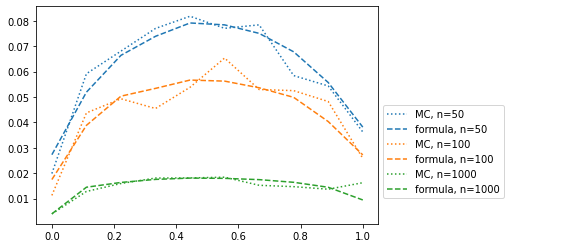

In [12]:
plt.figure(figsize=(10, 4))
for n, (eps, s1, s2) in data.items():
    l, = plt.plot(eps, s1, ":", label=f"MC, {n=}")
    plt.plot(eps, s2, "--", color=l.get_color(), label=f"formula, {n=}")
    print(f"{n=} median deviation {np.median(s1[s2 > 0] / s2[s2 > 0]) - 1:.2f}")
plt.subplots_adjust(right=0.6)
plt.figlegend(loc=(0.68, 0.2));

Again, the derived formula does reasonably well with deviations around 5 % for $n > 50$. This is usually sufficient to calculate error bars for efficiency plots. There should be some bias for small $n$ as before, but it is difficult to see here due to other larger random scatter, since I generated less toys to keep the computation time on my laptop reasonable.


Finally, I compare the uncertainty estimates for various levels of background. The estimate with zero background corresponds to the estimate which one obtains with the naive formula.

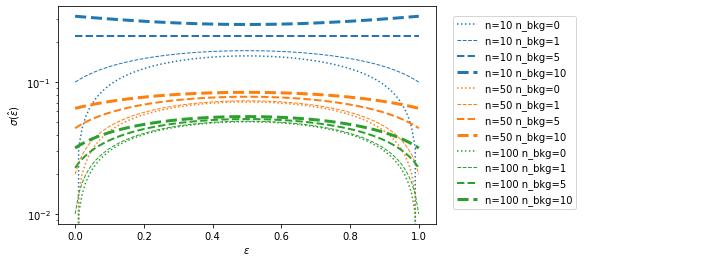

In [14]:
plt.figure(figsize=(14, 4))
eps = np.linspace(0, 1, 100)
for n in (10, 50, 100):
    n_pass = n * eps
    n_fail = n * (1 - eps)
    s1 = f_var(n_pass, n_fail) ** 0.5
    n_bkg = 0
    col = plt.plot(eps, s1, ":", label=f"{n=} {n_bkg=}")[0].get_color()
    for i, n_bkg in enumerate((1, 5, 10)):
        s2 = g_var(n_pass, (n_pass + n_bkg) ** 0.5, n_fail, (n_fail + n_bkg) ** 0.5) ** 0.5
        plt.plot(eps, s2, "--", color=col, lw=1 + i, label=f"{n=} {n_bkg=}")
plt.subplots_adjust(right=0.5)
plt.figlegend(loc=(0.64, 0.2))
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$\sigma(\hat \epsilon)$")
plt.semilogy();

The error of using a formula that neglects the background contribution is largest when the efficiency is close to zero or one.

These are frequently the interesting cases. For example, the [tracking efficency of the LHCb experiment]((https://doi.org/10.1088/1748-0221/10/02/P02007)) is estimated from fits to decays in calibration samples and the efficiency is around 96 %, so that the difference in the formulas may impact the estimated uncertainty.